# Give Me Some Credit

This notebook contains the full end‑to‑end workflow for the Kaggle *Give Me Some Credit* dataset.
Comments have been streamlined and imports consolidated for clarity.


In [ ]:
!pip install optbinning lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [ ]:
# Consolidated imports
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from optbinning import BinningProcess
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import make_scorer, fbeta_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

In [ ]:
df = pd.read_csv("cs-training.csv", index_col=0)

# Display shape and basic info
print("Shape:", df.shape)
print("\n--- Dataset Info ---")
print(df.info())
df.head()

Shape: (150000, 11)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents             

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


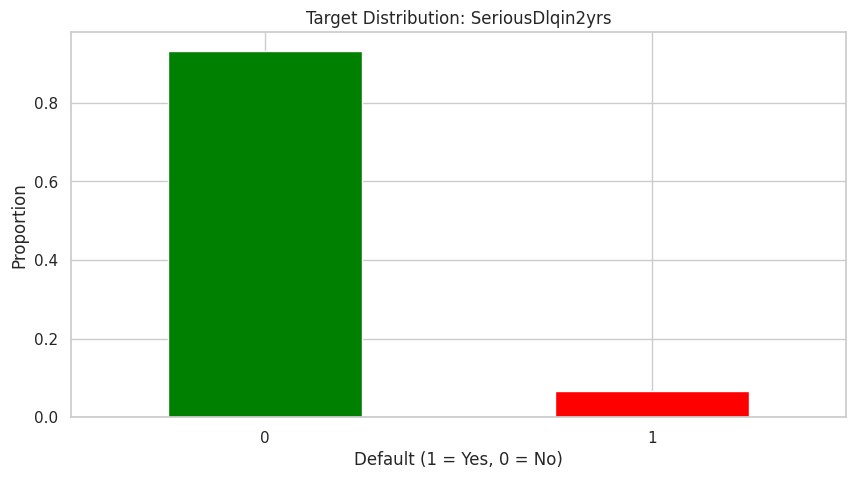

In [ ]:
# Target variable: 1 = default, 0 = no default
df['SeriousDlqin2yrs'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
plt.title("Target Distribution: SeriousDlqin2yrs")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Check total and percentage of missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_table = pd.DataFrame({"Missing Values": missing, "% of Total Rows": missing_percent})
missing_table = missing_table[missing_table["Missing Values"] > 0].sort_values(by="% of Total Rows", ascending=False)
print("\n--- Missing Value Report ---")
print(missing_table)


--- Missing Value Report ---
                    Missing Values  % of Total Rows
MonthlyIncome                29731        19.820667
NumberOfDependents            3924         2.616000


In [ ]:
print("\n--- Descriptive Statistics ---")
print(df.describe().T)


--- Descriptive Statistics ---
                                         count         mean           std  \
SeriousDlqin2yrs                      150000.0     0.066840      0.249746   
RevolvingUtilizationOfUnsecuredLines  150000.0     6.048438    249.755371   
age                                   150000.0    52.295207     14.771866   
NumberOfTime30-59DaysPastDueNotWorse  150000.0     0.421033      4.192781   
DebtRatio                             150000.0   353.005076   2037.818523   
MonthlyIncome                         120269.0  6670.221237  14384.674215   
NumberOfOpenCreditLinesAndLoans       150000.0     8.452760      5.145951   
NumberOfTimes90DaysLate               150000.0     0.265973      4.169304   
NumberRealEstateLoansOrLines          150000.0     1.018240      1.129771   
NumberOfTime60-89DaysPastDueNotWorse  150000.0     0.240387      4.155179   
NumberOfDependents                    146076.0     0.757222      1.115086   

                                      min  

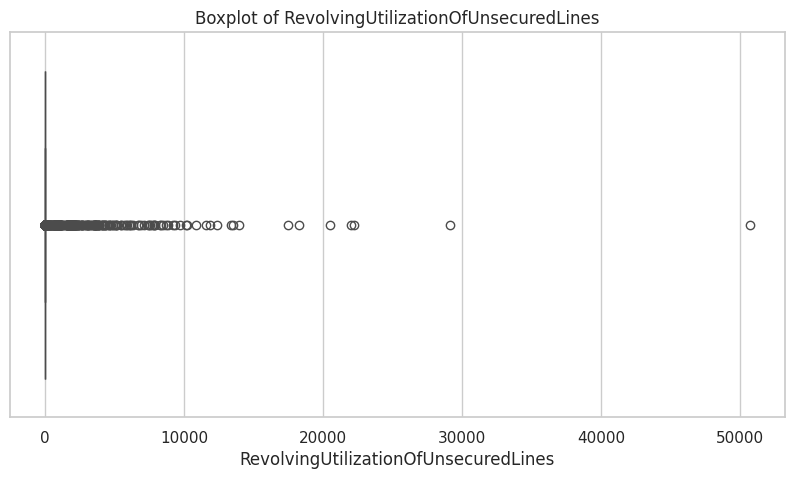

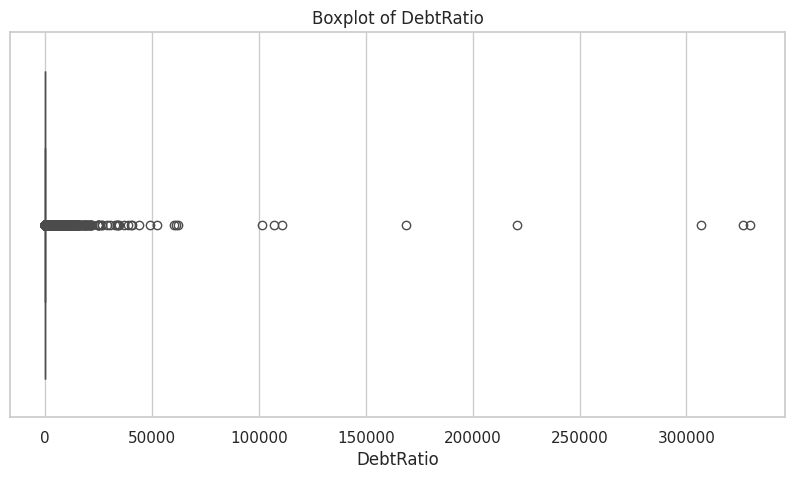

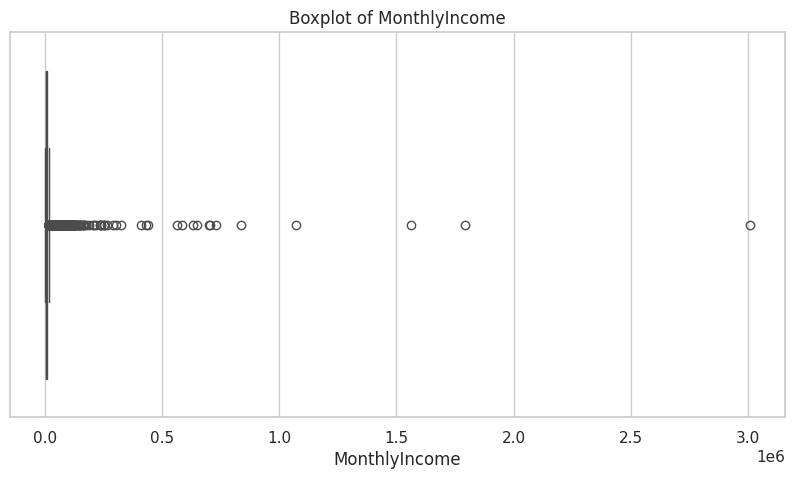

In [ ]:
# Boxplots for key numerical features
outlier_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']
for col in outlier_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

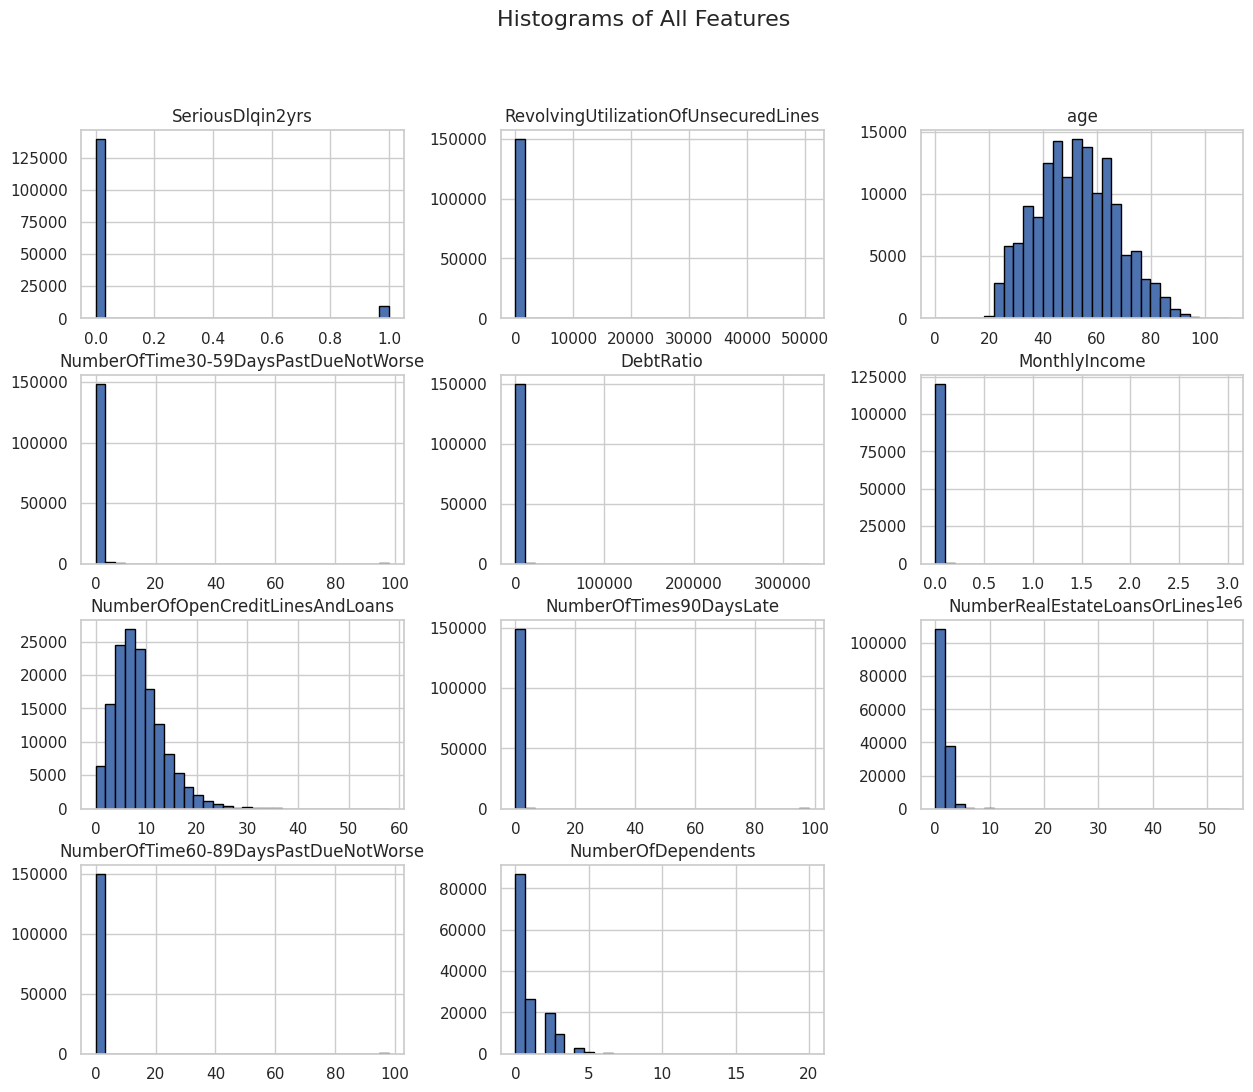

In [ ]:
# Histograms for all columns
df.hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of All Features", fontsize=16)
plt.show()

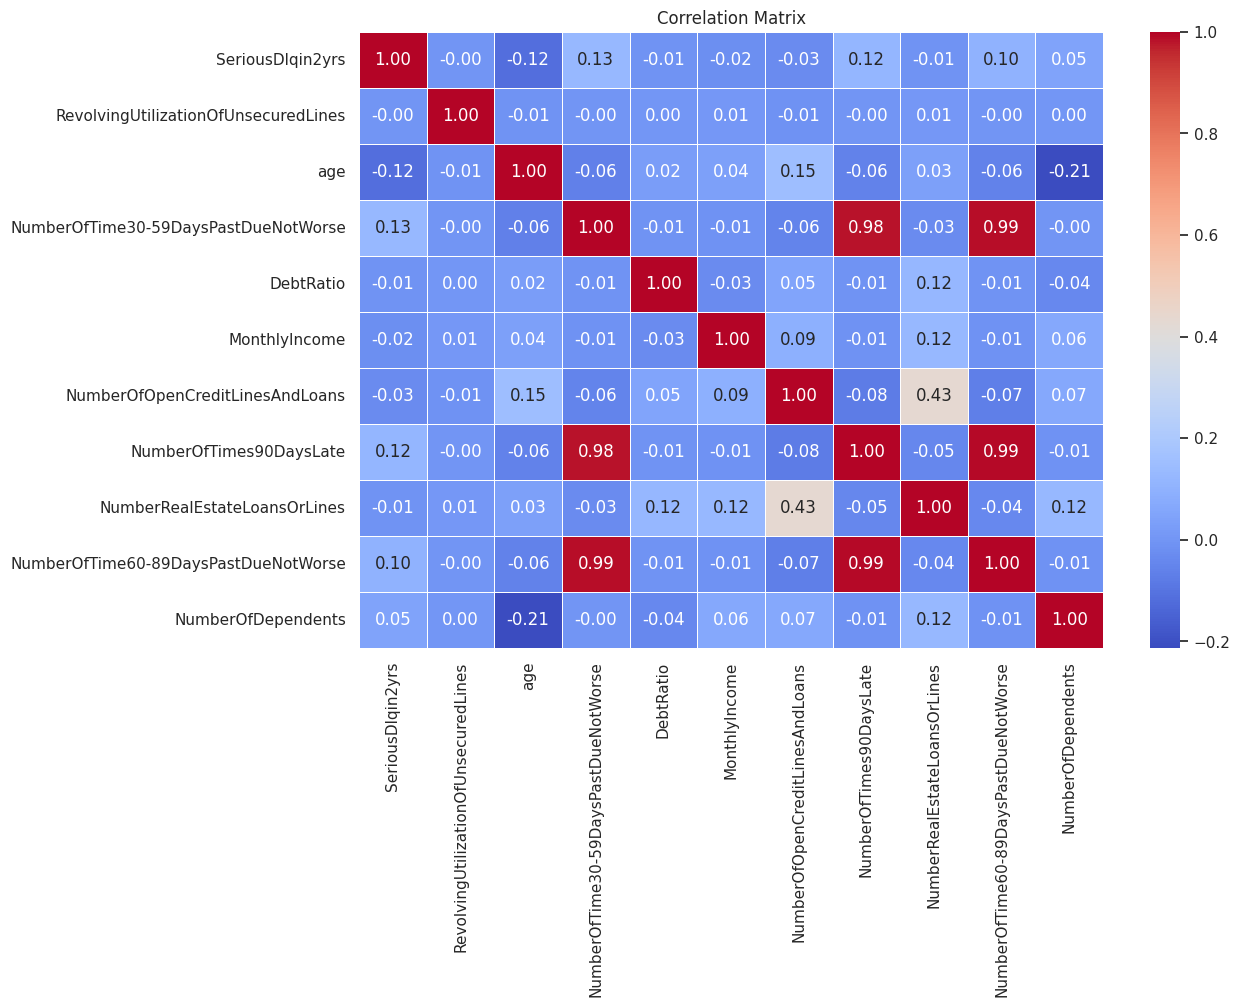

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

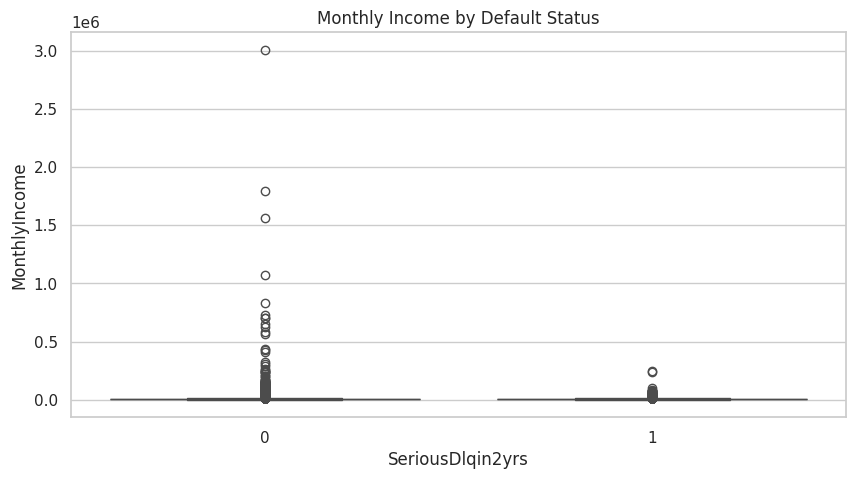

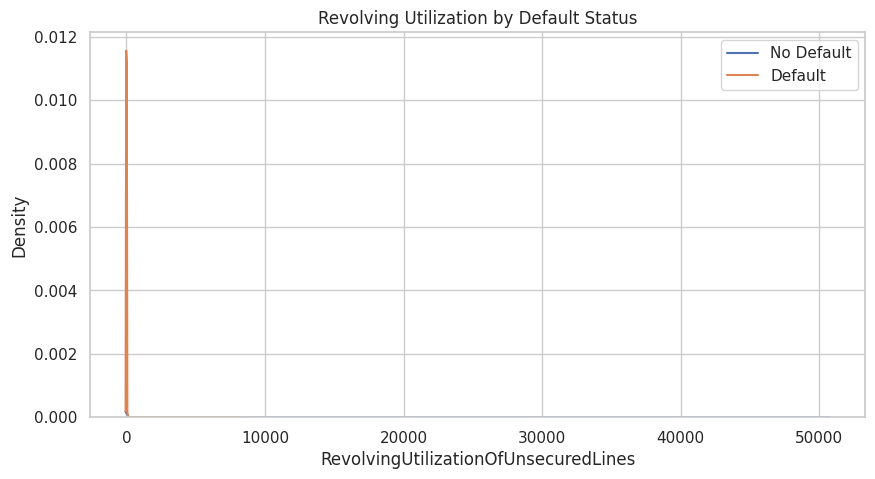

In [ ]:
# MonthlyIncome vs SeriousDlqin2yrs
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=df)
plt.title("Monthly Income by Default Status")
plt.show()

# RevolvingUtilization vs SeriousDlqin2yrs
sns.kdeplot(df[df['SeriousDlqin2yrs']==0]['RevolvingUtilizationOfUnsecuredLines'], label='No Default')
sns.kdeplot(df[df['SeriousDlqin2yrs']==1]['RevolvingUtilizationOfUnsecuredLines'], label='Default')
plt.title("Revolving Utilization by Default Status")
plt.xlabel("RevolvingUtilizationOfUnsecuredLines")
plt.legend()
plt.show()

In [ ]:
# Step 1: Copy original dataframe
df_clean = df.copy()

# Step 2: Select subset for KNN imputation
impute_cols = [
    'MonthlyIncome',
    'NumberOfDependents',
    'age',
    'DebtRatio',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'RevolvingUtilizationOfUnsecuredLines'
]

impute_df = df_clean[impute_cols]

# Step 3: Apply KNN Imputer (with default n_neighbors=5)
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(impute_df)

# Step 4: Convert back to DataFrame and replace columns
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=df_clean.index)
df_clean[impute_cols] = imputed_df

print("KNN Imputation Complete.")

KNN Imputation Complete.


In [ ]:
# Cap RevolvingUtilizationOfUnsecuredLines at 1.0
df_clean['RevolvingUtilizationOfUnsecuredLines'] = df_clean['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1.0)

# Cap DebtRatio at 95th percentile
debt_cap = df_clean['DebtRatio'].quantile(0.95)
df_clean['DebtRatio'] = df_clean['DebtRatio'].clip(upper=debt_cap)

# Cap age to minimum 18
df_clean['age'] = df_clean['age'].clip(lower=18)

print("Outlier Capping Complete.")

Outlier Capping Complete.


In [ ]:
# Apply log1p (log(x + 1)) to skewed features
df_clean['MonthlyIncome_log'] = np.log1p(df_clean['MonthlyIncome'])
df_clean['DebtRatio_log'] = np.log1p(df_clean['DebtRatio'])

# Optional: drop raw columns if you're done using them
# df_clean.drop(['MonthlyIncome', 'DebtRatio'], axis=1, inplace=True)

print("Log Transform Applied.")

Log Transform Applied.


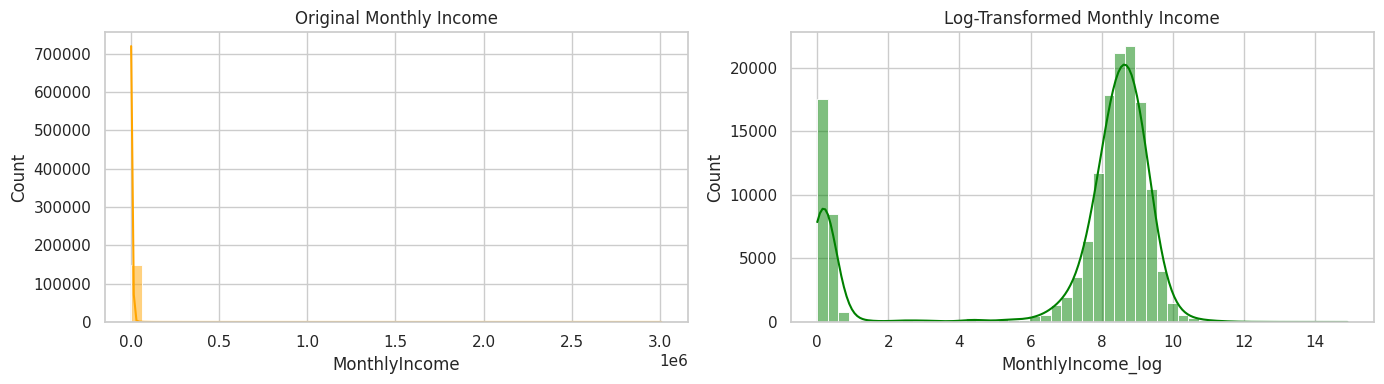

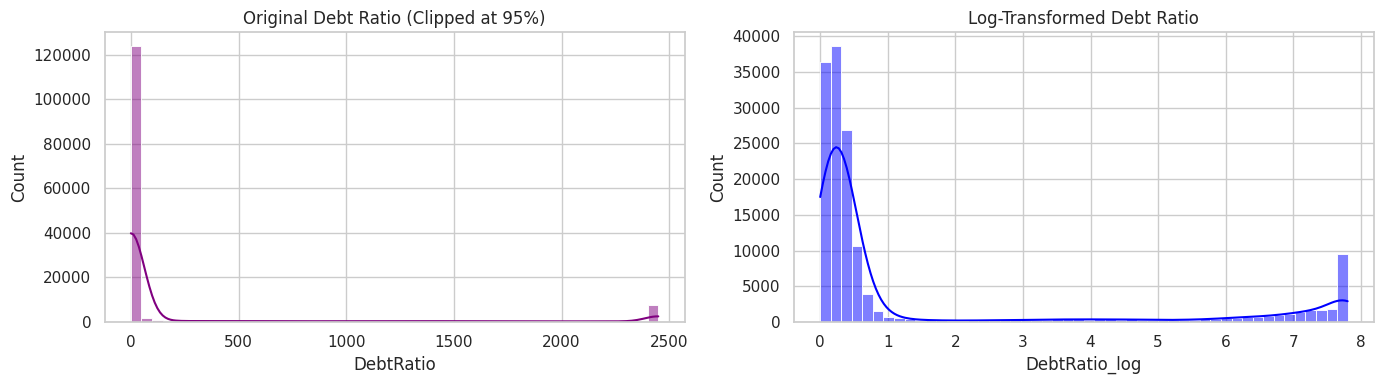

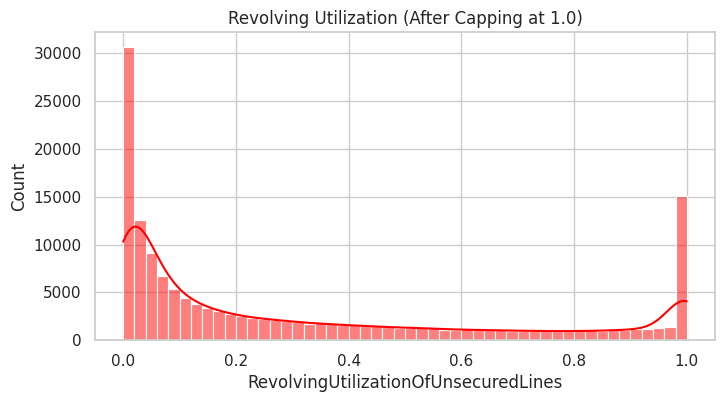

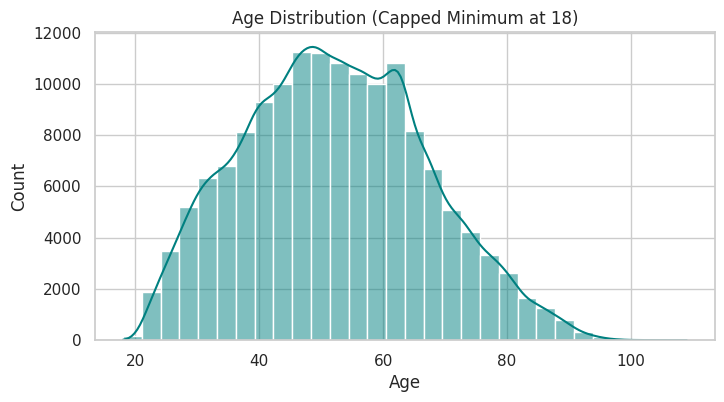

In [ ]:
# 1. Monthly Income (Before vs After Log)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_clean['MonthlyIncome'], bins=50, kde=True, ax=axes[0], color='orange')
axes[0].set_title("Original Monthly Income")

sns.histplot(df_clean['MonthlyIncome_log'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title("Log-Transformed Monthly Income")
plt.tight_layout()
plt.show()

# 2. DebtRatio (Before vs After Log)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df_clean['DebtRatio'], bins=50, kde=True, ax=axes[0], color='purple')
axes[0].set_title("Original Debt Ratio (Clipped at 95%)")

sns.histplot(df_clean['DebtRatio_log'], bins=50, kde=True, ax=axes[1], color='blue')
axes[1].set_title("Log-Transformed Debt Ratio")
plt.tight_layout()
plt.show()

# 3. RevolvingUtilizationOfUnsecuredLines (After Capping)
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['RevolvingUtilizationOfUnsecuredLines'], bins=50, kde=True, color='red')
plt.title("Revolving Utilization (After Capping at 1.0)")
plt.xlabel("RevolvingUtilizationOfUnsecuredLines")
plt.show()

# 4. Age Distribution (After Capping)
plt.figure(figsize=(8, 4))
sns.histplot(df_clean['age'], bins=30, kde=True, color='teal')
plt.title("Age Distribution (Capped Minimum at 18)")
plt.xlabel("Age")
plt.show()

In [ ]:
# Make a copy to build modeling features
df_model = df_clean.copy()

# 1. Binary: Any history of late payment
df_model['HasLatePayments'] = (
    (df_model['NumberOfTime30-59DaysPastDueNotWorse'] > 0) |
    (df_model['NumberOfTime60-89DaysPastDueNotWorse'] > 0) |
    (df_model['NumberOfTimes90DaysLate'] > 0)
).astype(int)

# 2. Max severity of delinquency
df_model['MaxDelinquencySeverity'] = df_model[[
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]].max(axis=1)

# 3. Sum of delinquencies and normalized frequency
df_model['LatePaymentSum'] = (
    df_model['NumberOfTime30-59DaysPastDueNotWorse'] +
    df_model['NumberOfTime60-89DaysPastDueNotWorse'] +
    df_model['NumberOfTimes90DaysLate']
)
df_model['DelinquencyFrequency'] = df_model['LatePaymentSum'] / df_model['age']

# 4. Open credit lines per year of age
df_model['OpenLinesToAgeRatio'] = df_model['NumberOfOpenCreditLinesAndLoans'] / df_model['age']

# 5. Utilization to income ratio
df_model['UtilizationToIncomeRatio'] = df_model['RevolvingUtilizationOfUnsecuredLines'] / (df_model['MonthlyIncome'] + 1)

# 6. Custom weighted risk score
df_model['RiskScore'] = (
    1 * df_model['NumberOfTime30-59DaysPastDueNotWorse'] +
    2 * df_model['NumberOfTime60-89DaysPastDueNotWorse'] +
    3 * df_model['NumberOfTimes90DaysLate']
)

print("Final Feature Engineering Complete — domain-inspired features added.")

Final Feature Engineering Complete — domain-inspired features added.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


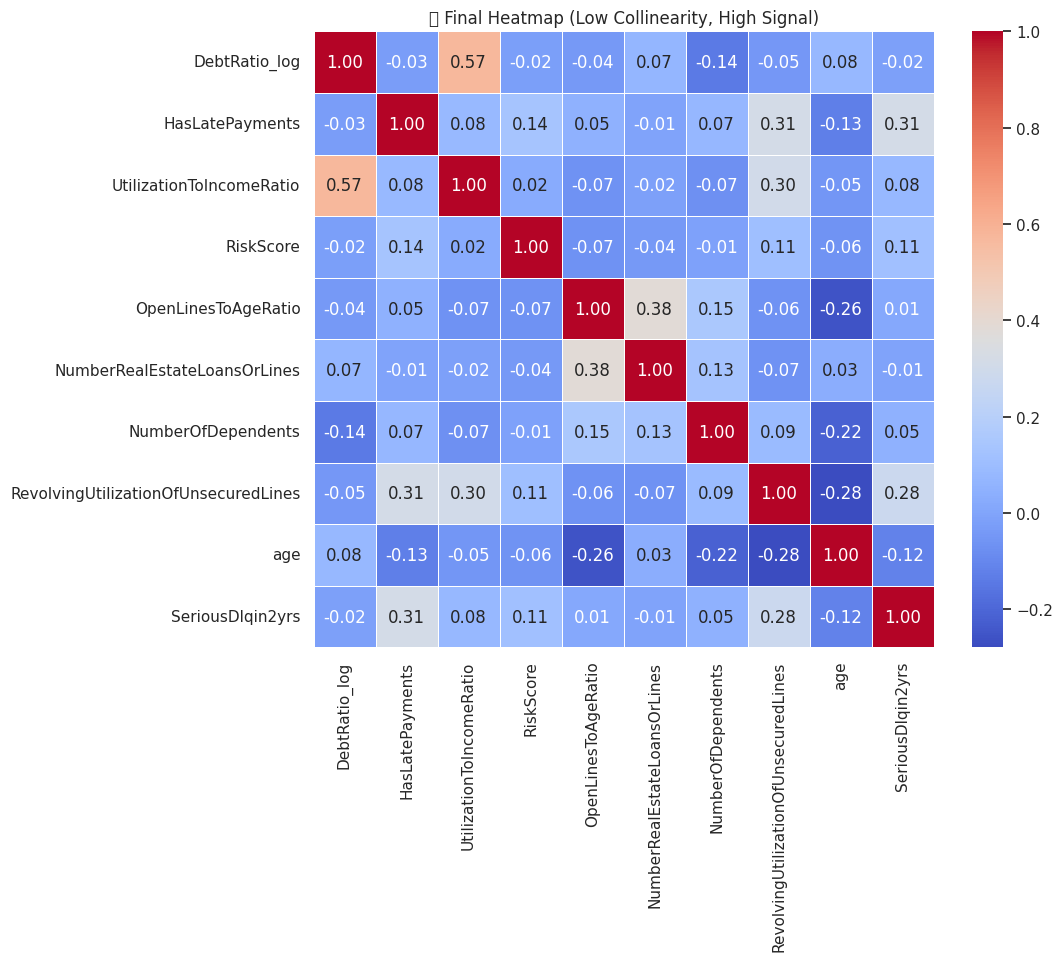

In [ ]:
# Define cleaned and de-correlated feature set
de_corr_features = [
    'DebtRatio_log',
    'HasLatePayments',
    'UtilizationToIncomeRatio',
    'RiskScore',
    'OpenLinesToAgeRatio',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'SeriousDlqin2yrs'
]

# Create final dataframe
df_final_model = df_model[de_corr_features]

plt.figure(figsize=(10, 8))
sns.heatmap(df_final_model.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("🧼 Final Heatmap (Low Collinearity, High Signal)")
plt.show()

In [ ]:
# Replace this with your final, cleaned, engineered DataFrame
df_final_model = df_model[[
    'DebtRatio_log',
    'HasLatePayments',
    'UtilizationToIncomeRatio',
    'RiskScore',
    'OpenLinesToAgeRatio',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'SeriousDlqin2yrs'
]]


 Training: Logistic Regression


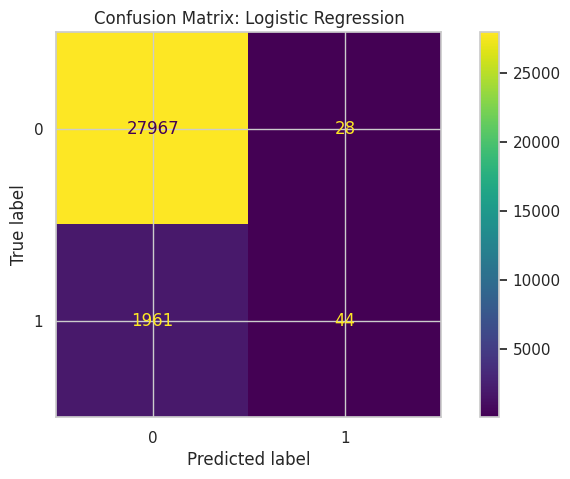

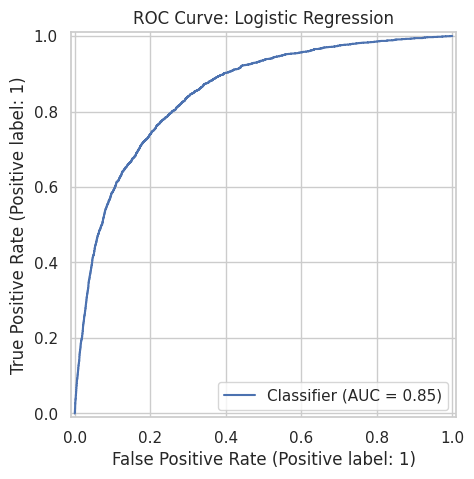


 Training: Random Forest


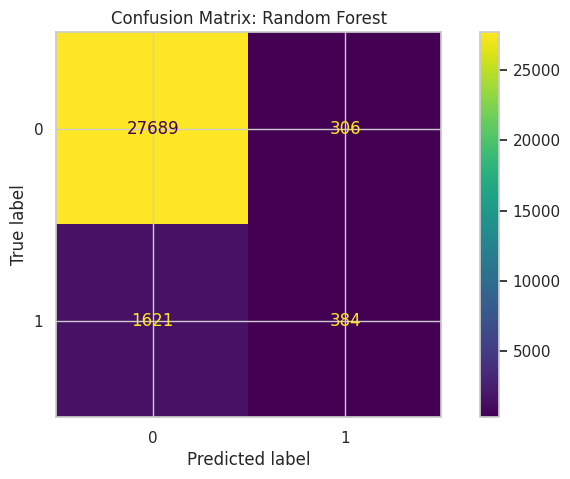

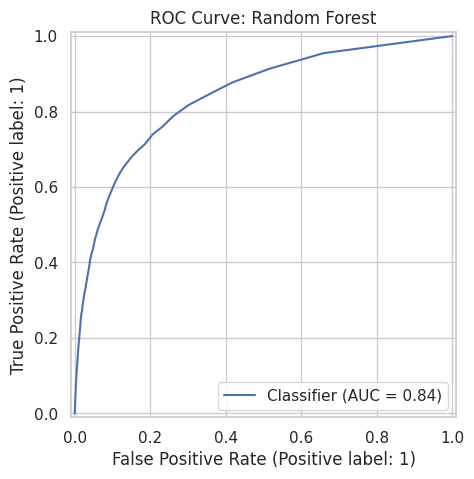


 Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:15:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


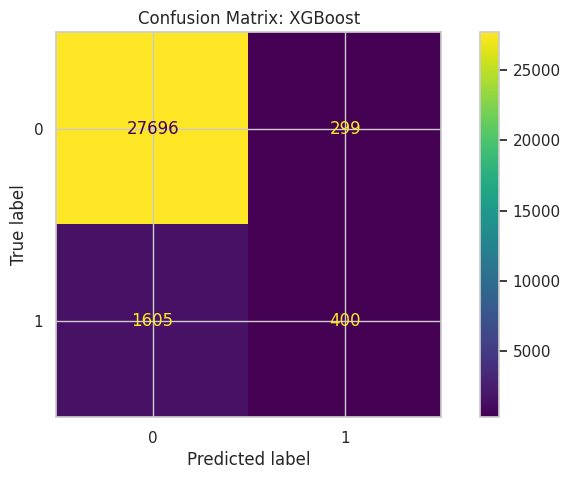

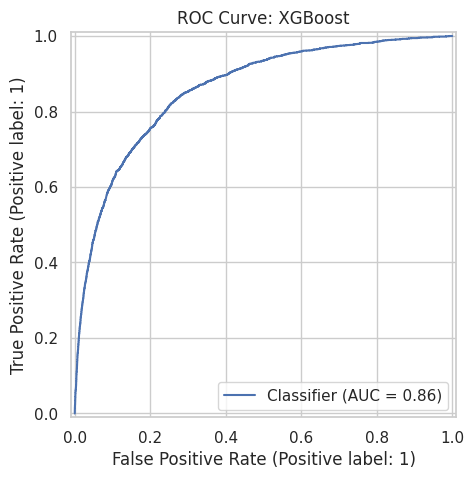


 Training: LightGBM
[LightGBM] [Info] Number of positive: 8021, number of negative: 111979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066842 -> initscore=-2.636248
[LightGBM] [Info] Start training from score -2.636248


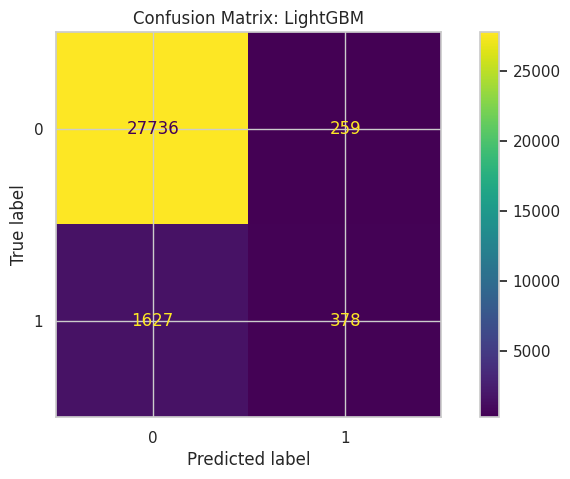

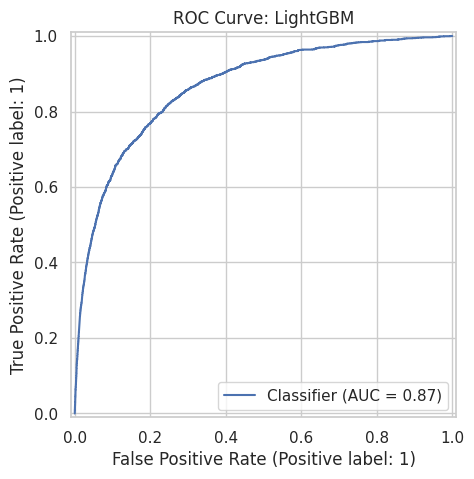

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LightGBM,0.937133,0.593407,0.188529,0.286147,0.866989
1,XGBoost,0.936533,0.572246,0.199501,0.295858,0.860254
2,Logistic Regression,0.933700,0.611111,0.021945,0.042369,0.851544
3,Random Forest,0.935767,0.556522,0.191521,0.284972,0.840344


In [ ]:
# Train-test split
X = df_final_model.drop("SeriousDlqin2yrs", axis=1)
y = df_final_model["SeriousDlqin2yrs"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Train, evaluate, and plot
results = []
for name, model in models.items():
    print(f"\n Training: {name}")

    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        X_eval = X_test_scaled
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        X_eval = X_test

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_eval, y_test)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve: {name}")
    plt.show()

# Compare results
results_df = pd.DataFrame(results)
results_df.sort_values("ROC AUC", ascending=False).reset_index(drop=True)

In [ ]:
# Step 1: Class imbalance weight
# (scale_pos_weight = num_neg / num_pos)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Step 2: Define XGBoost + param grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Step 3: Define scoring (F2 favors recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Step 4: Grid search
grid = GridSearchCV(xgb, param_grid, cv=3, scoring=f2_scorer, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

scale_pos_weight: 13.96
Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


              precision    recall  f1-score   support

           0       0.98      0.81      0.88     27995
           1       0.22      0.77      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.85     30000

ROC AUC: 0.8677232352232476


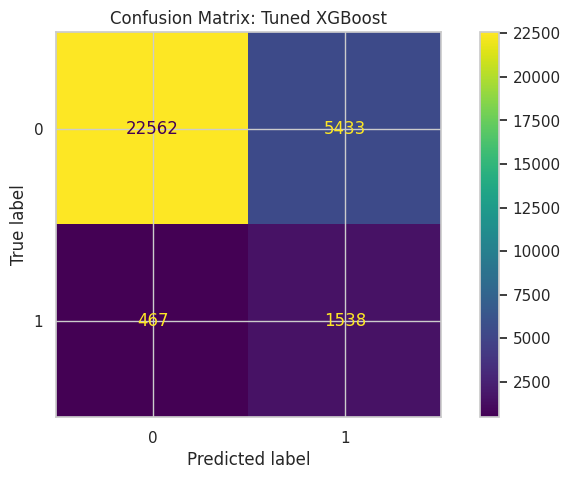

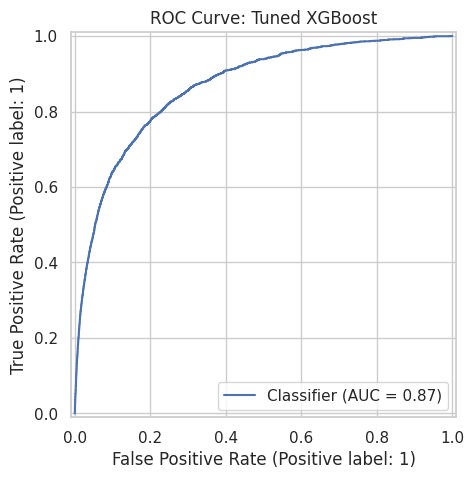

In [ ]:
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("Confusion Matrix: Tuned XGBoost")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve: Tuned XGBoost")
plt.show()

In [ ]:
# Predict probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Find optimal threshold using F2 score
thresholds = np.linspace(0, 1, 100)
f2_scores = [fbeta_score(y_test, y_proba > t, beta=2) for t in thresholds]

best_thresh = thresholds[np.argmax(f2_scores)]
print(f"Optimal Threshold for F2: {best_thresh:.2f}")

# Apply threshold
y_pred_thresh = (y_proba > best_thresh).astype(int)

# Final classification report
print(classification_report(y_test, y_pred_thresh))
confusion_matrix(y_test, y_pred_thresh)

Optimal Threshold for F2: 0.61
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     27995
           1       0.30      0.65      0.41      2005

    accuracy                           0.88     30000
   macro avg       0.64      0.77      0.67     30000
weighted avg       0.93      0.88      0.90     30000



array([[24959,  3036],
       [  692,  1313]])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:19:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Optimal threshold for F2: 0.39
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     27995
           1       0.22      0.69      0.33      2005

    accuracy                           0.81     30000
   macro avg       0.59      0.75      0.61     30000
weighted avg       0.92      0.81      0.85     30000

Confusion Matrix:
 [[22999  4996]
 [  625  1380]]


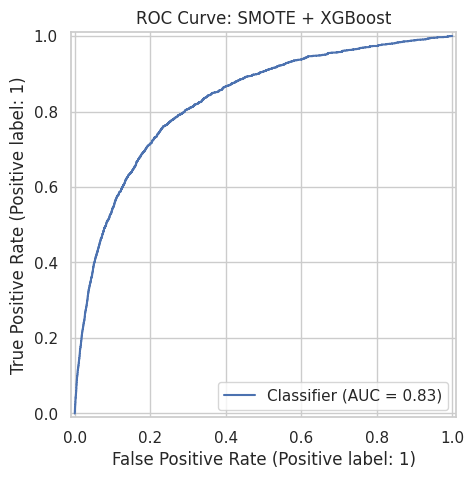

In [ ]:
X = df_final_model.drop("SeriousDlqin2yrs", axis=1)
y = df_final_model["SeriousDlqin2yrs"]

# Split original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE on train
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train XGBoost on resampled data
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
xgb_smote.fit(X_resampled, y_resampled)

# Predict probabilities on test set
y_proba_smote = xgb_smote.predict_proba(X_test)[:, 1]

# Find optimal threshold using F2 Score
thresholds = np.linspace(0.1, 0.9, 100)
f2_scores = [fbeta_score(y_test, y_proba_smote > t, beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f2_scores)]
print(f" Optimal threshold for F2: {best_thresh:.2f}")

# Final predictions
y_pred_thresh = (y_proba_smote > best_thresh).astype(int)

#  Evaluation
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_smote)
plt.title("ROC Curve: SMOTE + XGBoost")
plt.show()

In [ ]:
# Re-SMOTE to be safe
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Define custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1]  # since SMOTE is used
}

# Initialize base model
xgb_base = XGBClassifier(
    eval_metric='logloss', use_label_encoder=False, random_state=42
)

# Randomized Search
search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring=f2_scorer,
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit
search.fit(X_resampled, y_resampled)

# Best model
best_xgb_tuned = search.best_estimator_
print("Best Params:", search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:24:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Params: {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


New Optimal Threshold: 0.31
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     27995
           1       0.20      0.68      0.32      2005

    accuracy                           0.80     30000
   macro avg       0.59      0.75      0.60     30000
weighted avg       0.92      0.80      0.85     30000

Confusion Matrix:
 [[22701  5294]
 [  640  1365]]


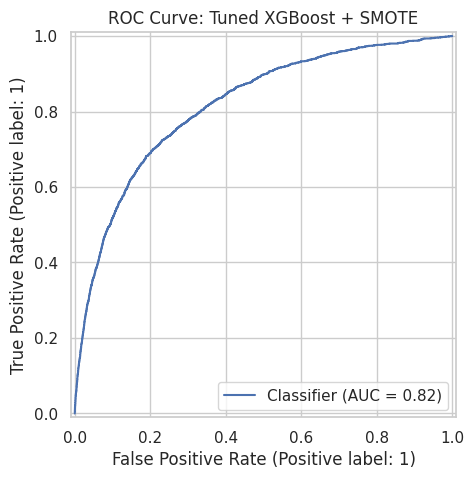

In [ ]:
# Predict on test set
y_proba_tuned = best_xgb_tuned.predict_proba(X_test)[:, 1]

# Re-tune threshold
thresholds = np.linspace(0.1, 0.9, 100)
f2_scores = [fbeta_score(y_test, y_proba_tuned > t, beta=2) for t in thresholds]
best_thresh_tuned = thresholds[np.argmax(f2_scores)]
print(f"New Optimal Threshold: {best_thresh_tuned:.2f}")

# Final predictions
y_pred_tuned = (y_proba_tuned > best_thresh_tuned).astype(int)

# Metrics
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba_tuned)
plt.title("ROC Curve: Tuned XGBoost + SMOTE")
plt.show()

In [ ]:
# Select features to bin
features_to_bin = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'DebtRatio',
    'MonthlyIncome_log',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

# Prepare data
X_bin = df_model[features_to_bin].copy()
y_bin = df_model["SeriousDlqin2yrs"].copy()

# Fill missing values (if any)
X_bin = X_bin.fillna(-999)

# Create binning process (no monotonic constraint)
binning_process = BinningProcess(variable_names=features_to_bin)
X_binned = binning_process.fit_transform(X_bin, y_bin)

# Rename binned columns
X_binned.columns = [f"{col}_woe" for col in X_binned.columns]

# Merge with original engineered features
X_engineered = df_model.drop("SeriousDlqin2yrs", axis=1).copy()
X_engineered = pd.concat([X_engineered.reset_index(drop=True), X_binned.reset_index(drop=True)], axis=1)

# Define final target and predictors
y_final = df_model["SeriousDlqin2yrs"]
X_final = X_engineered.drop(features_to_bin, axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

print("WoE encoding completed successfully.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

WoE encoding completed successfully.


In [ ]:
# Initialize and train logistic model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Results:
[[22623  5372]
 [  481  1524]]
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     27995
           1       0.22      0.76      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.78      0.61     30000
weighted avg       0.93      0.80      0.85     30000

ROC AUC Score: 0.8638909334985452


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Initialize and train XGBoost
xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Results:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
[[27771   224]
 [ 1636   369]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.62      0.18      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000

ROC AUC Score: 0.8691871410952883
